# Modelos de clasificación

**Autor/es:**
+ Luis Saez
+ Erwin Nuñez

**Correos Electrónicos:**
+ lu.saezd@duocuc.cl
+ er.nunez@duocuc.cl

**Fecha de Creación:** 19 de Noviembre del 2024  
**Versión:** 1.0

---

## Descripción

Este notebook contiene el desarrollo de la evaluación de modelos de regresión de la asignatura de Fundamentos de Machine Learning de la carrera de Ingeniería en informática de DuocUC - Sede Concepción


In [ ]:
!wget https://www.dropbox.com/s/sst1u94436vqca6/demo_round_traces.csv

--2024-11-19 22:23:28--  https://www.dropbox.com/s/sst1u94436vqca6/demo_round_traces.csv
Resolving www.dropbox.com (www.dropbox.com)... 162.125.13.18, 2620:100:6028:18::a27d:4712
Connecting to www.dropbox.com (www.dropbox.com)|162.125.13.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/ujmigz0ky1r9ps75u8h1d/demo_round_traces.csv?rlkey=24f4k6ipomzkq1lj8kz2gayds [following]
--2024-11-19 22:23:28--  https://www.dropbox.com/scl/fi/ujmigz0ky1r9ps75u8h1d/demo_round_traces.csv?rlkey=24f4k6ipomzkq1lj8kz2gayds
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uce9ec96dfd1149331dcbaf97515.dl.dropboxusercontent.com/cd/0/inline/Cevd9eqFWlPEJmu5d0xc6bq8HpIbBecR94wRYa95W5DIvLH2sfcU3ptvcLY8RZz13CSDdQNfjVjmT4FfEZ3y1VFgGc4yZkwmAxC5e75-WeLTgRYHm7d8mnbpRsiAe9gMiDOBffkfDd6eDF-O3Up-zNw9/file# [following]
--2024-11-19 22:23:29--  https://uce9ec96dfd1149331dcbaf97515.dl.dropbo

# Contexto del negocio



Se nos entrego un set de datos el cual contiene los resultados de unas partidas competitivas del Counter-Strike donde podemos contemplar el rendimiento de los jugadores en las distintas partidas.

Se nos pidio evaluar los datos y poder identificar si existe algo "interesante" para generar un modelo que pueda entregar informacion relevante a los sponsor de los equipos competitivos para futuras competencias dentro del juego.

---

En base al dataset entregado, seria interesante poder evaluar si un jugador sobrevive o no en una ronda especifica **(Survived)**, esto puede permitirle a los distintos sponsors poder evaluar, en base a distintos factores, si un jugador es capaz de desempeñar correctamente el rol en su equipo sin llegar a realizar acciones/jugadas muy arriesgadas que le cuesten la vida.

Para poder medir estos factores se tomaron las siguientes caracteristicas:

- ScaledTimeAlive: Indica, en una escala logaritmica, el tiempo de vida de un jugador en una ronda especifica.

- RoundStartingEquipmentValue: Indica el valor (currency) del equipamiento del jugador al inicio de la ronda.

- RoundKills: Indica la cantidad de asesinatos, independientemente del tipo, que tuvo un jugador en una ronda especifica.

- AvgKillDistance: Indica, en promedio, la distancia de asesinato de un jugador en una ronda especifica.

# Objetivo

Desarrollar modelos de clasificación para predecir la probabilidad de supervivencia de un jugador en una ronda específica de Counter-Strike **(Survived)**, basándose en factores como el tiempo de vida, el valor del equipamiento al inicio de la ronda, la cantidad de asesinatos realizados y la distancia promedio de los asesinatos. Este modelo permitirá proporcionar información clave a los patrocinadores de equipos competitivos, ayudándoles a evaluar el desempeño y la toma de decisiones de los jugadores en situaciones de riesgo.

# Preparación del entorno

In [ ]:
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from seaborn import lmplot, boxplot, violinplot, kdeplot
from tabulate import tabulate
import random
import scipy.stats as stats
from ipywidgets import interactive
from scipy.stats import norm
import math
import numpy as np
import json

from sklearn.preprocessing import StandardScaler
from sklearn import metrics

from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score, precision_score,  classification_report, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.decomposition import PCA

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.base import BaseEstimator

In [ ]:
def get_best_model_by_f1(models, X_test, y_test):
    """
    Calcula el F1-score de cada modelo y retorna el modelo con el mejor puntaje.

    Parameters:
        models (dict): Diccionario con nombres de modelos como claves y objetos de modelos como valores.
        X_test (array-like): Conjunto de datos de prueba (características).
        y_test (array-like): Etiquetas reales de prueba.

    Returns:
        tuple: El nombre del mejor modelo y su F1-score.
    """
    best_model_name = None
    best_f1_score = 0
    f1_scores = {}

    for model_name, model in models.items():
        # Predicción usando el modelo actual
        y_pred = model.predict(X_test)
        # Cálculo del F1-score
        score = f1_score(y_test, y_pred, average="weighted")  # Usamos 'weighted' para datos no balanceados
        f1_scores[model_name] = score

        # Actualizamos si encontramos un modelo con mejor F1-score
        if score > best_f1_score:
            best_f1_score = score
            best_model_name = model_name

    print("F1 Scores de los modelos:", f1_scores)
    return best_model_name, best_f1_score

In [ ]:
def view_matriz(model : BaseEstimator, X_test : pd.DataFrame, y_test : pd.Series,
                clases : np.array, model_title : str):
  # Matriz de confusión de forma gráfica
  matriz = confusion_matrix(y_test, model.predict(X_test))
  plt.figure(figsize=(5,5),facecolor= 'silver')
  group_counts = ["{0:0.0f}".format(value) for value in matriz.flatten()]
  group_percentages = ["{0:.2%}".format(value) for value in matriz.flatten()/matriz.sum()]
  labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts,group_percentages)]
  labels = np.asarray(labels).reshape(2,2)
  sns.heatmap(matriz, annot=labels, fmt='', cmap='Blues', xticklabels=clases, yticklabels=clases)
  plt.title(f"Matriz de confusión {model_title}", fontsize=15, fontweight="bold")
  plt.xlabel("Predicción", fontsize=10)
  plt.ylabel("Real", fontsize=10)
  plt.show()

# Carga de la data

In [ ]:
counter_strike = pd.read_csv('demo_round_traces.csv', sep=';')
counter_strike.head()

,Unnamed: 0,Map,Team,InternalTeamId,MatchId,RoundId,SteamId,RoundWinner,MatchWinner,Survived,...,RoundAssists,RoundHeadshots,RoundFlankKills,RoundStartingEquipmentValue,TeamStartingEquipmentValue,MatchKills,MatchFlankKills,MatchAssists,MatchHeadshots,AvgMatchKillDist
0,600,de_inferno,Terrorist,1,4,1,76561198036987787,False,True,False,...,0,0,0,750,4400,0,0,0,0,501379.183091
1,601,de_inferno,Terrorist,1,4,1,76561197971812216,False,True,False,...,0,0,0,800,4400,0,0,0,0,208807.587297
2,602,de_inferno,Terrorist,1,4,1,76561197972240652,False,True,False,...,0,0,0,1000,4400,0,0,0,0,381652.027911
3,603,de_inferno,Terrorist,1,4,1,76561197975824962,False,True,False,...,0,0,0,850,4400,0,0,0,0,289754.503091
4,604,de_inferno,Terrorist,1,4,1,76561197960331095,False,True,True,...,0,0,0,1000,4400,0,0,0,0,254527.691176


In [ ]:
counter_strike.shape

(79157, 37)

In [ ]:
counter_strike.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79157 entries, 0 to 79156
Data columns (total 37 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Unnamed: 0                   79157 non-null  int64  
 1   Map                          79157 non-null  object 
 2   Team                         79157 non-null  object 
 3   InternalTeamId               79157 non-null  int64  
 4   MatchId                      79157 non-null  int64  
 5   RoundId                      79157 non-null  int64  
 6   SteamId                      79157 non-null  int64  
 7   RoundWinner                  79157 non-null  bool   
 8   MatchWinner                  79157 non-null  bool   
 9   Survived                     79157 non-null  bool   
 10  AbnormalMatch                79157 non-null  bool   
 11  TimeAlive                    79157 non-null  float64
 12  ScaledTimeAlive              79157 non-null  float64
 13  AvgCentroidDista

# Fase 2 - Comprensión de los datos

In [ ]:
# Transformamos la  variable booleana Survived a numerica (0 - 1)
counter_strike["Survived"] = counter_strike["Survived"].astype(int)

Transformamos survived a un valor numerico para poder incluirlos al metodo del dataset que indica las variables con mayor correlacion hacia esa caracteristica especifica.

In [ ]:
matriz_corr = counter_strike[counter_strike.describe().columns].corr()
matriz_corr["Survived"].sort_values(ascending=False)

,Survived
Survived,1.000000
ScaledTimeAlive,0.658926
RoundKills,0.331619
TimeAlive,0.224926
RoundHeadshots,0.205279
AvgKillDistance,0.190699
TeamStartingEquipmentValue,0.173237
RLethalGrenadesThrown,0.171732
RoundStartingEquipmentValue,0.170578
AvgCentroidDistance,0.140934


En base a la correlacion que nos entrega la anterior tabla y la representatividad de cada una de las caracteristicas decidimos utilizar las siguientes caracteristicas para predecir survived:

- ScaledTimeAlive: Indica, en una escala logaritmica, el tiempo de vida de un jugador en una ronda especifica.

- RoundStartingEquipmentValue: Indica el valor (currency) del equipamiento del jugador al inicio de la ronda.

- RoundKills: Indica la cantidad de asesinatos, independientemente del tipo, que tuvo un jugador en una ronda especifica.

- AvgKillDistance: Indica, en promedio, la distancia de asesinato de un jugador en una ronda especifica.

In [ ]:
caracteristicas = ["Survived", "ScaledTimeAlive", "RoundStartingEquipmentValue", "RoundKills", "AvgKillDistance"]
data = counter_strike[caracteristicas]

In [ ]:
survived_discreta = data["Survived"].astype("category")
survived_discreta.describe()

,Survived
count,79157
unique,2
top,0
freq,47214


En base al resumen estadistico que nos genera pandas tomando en cuenta que es una variable discreta podemos identificar que:

- No existen valores nulos ya que survived posee 79.157 valores dentro de un dataset que tiene la misma cantidad de filas

- Es una variable binaria ya que se indica que solo posee unicamente 2 valores **(0 y 1)**

- El valor mas frecuente es el valor **(0)** que indica que el jugador no sobrevivio en dicha ronda, teniendo en cuenta que dicho valor esta presente en 47.214 de los 79.157 registros.



In [ ]:
outliers = {}
for carac in caracteristicas:
  data["z-score"] = (data[carac] - data[carac].mean()) / data[carac].std()
  cantidad_outliers = (np.abs(data["z-score"]) > 3).sum()
  outliers[carac] = cantidad_outliers

print("****************************************************************************\n")
print("Cantidad de outliers en cada una de las caracteristicas: \n {}".format(outliers))

****************************************************************************

Cantidad de outliers en cada una de las caracteristicas: 
 {'Survived': 0, 'ScaledTimeAlive': 246, 'RoundStartingEquipmentValue': 0, 'RoundKills': 591, 'AvgKillDistance': 1459}


<ipython-input-101-ef86c223e82d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["z-score"] = (data[carac] - data[carac].mean()) / data[carac].std()


Con esto podemos identificar que algunas de nuestras caracteristicas tienen presencia de valores atipicos, aun asi no son valores tan elevados ya que la mas alta es el AvgKillDistance que posee 1.459 pero representa el 1,84% de los datos aun asi es recomendable aplicar algun tipo de tratamiento a estos valores para evitar que el rendimiento de nuestro modelo sea afectado.

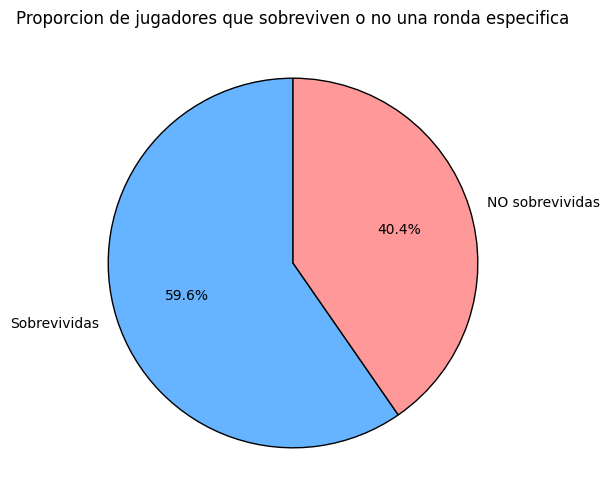

In [ ]:
labels = ['Sobrevivieron', 'NO Sobrevivieron']
colors = ['#66b3ff', '#ff9999']

plt.figure(figsize=(8, 6))
plt.pie(data["Survived"].value_counts(), labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, wedgeprops={'edgecolor': 'black'})
plt.title('Proporcion de jugadores que sobreviven o no una ronda especifica')
plt.show()

Como podemos observar en el grafico, existe un sesgo en los datos ya que hay mas presencia de observaciones de jugadores que sobreviven la ronda, siendo que el 59.6% de los jugadores sobreviven la ronda, esto puede afectar nuestro modelo debido al desbalance de clases.

# Fase 3 - Preparación de los datos

In [ ]:
caracteristicas_ind = ["ScaledTimeAlive", "RoundStartingEquipmentValue", "RoundKills", "AvgKillDistance"]
scaler = StandardScaler()

data[caracteristicas_ind] = scaler.fit_transform(data[caracteristicas_ind])

print(data.head())

   Survived  ScaledTimeAlive  RoundStartingEquipmentValue  RoundKills  \
0         0         0.629611                    -1.434258   -0.761346   
1         0        -0.051939                    -1.410576   -0.761346   
2         0        -0.599413                    -1.315846   -0.761346   
3         0         0.322355                    -1.386893   -0.761346   
4         1         0.808378                    -1.315846   -0.761346   

   AvgKillDistance   z-score  
0        -0.477179 -0.477176  
1        -0.477179 -0.477176  
2        -0.477179 -0.477176  
3        -0.477179 -0.477176  
4        -0.477179 -0.477176  


<ipython-input-103-b8653498f833>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[caracteristicas_ind] = scaler.fit_transform(data[caracteristicas_ind])


Realizamos un escalado de los datos para que todas las variables mantengan un mismo rango de digitos, esto permitira que no hayan valores que se escapen en escala a los demas y ayudara a mejorar el rendimiento de nuestro modelo

In [ ]:
pca = PCA(n_components=3)
# Buscar los componentes principales
pca.fit(data[caracteristicas_ind])
X_pca = pca.transform(data[caracteristicas_ind])
# Imprime la forma del array
print("shape of X_pca", X_pca.shape)

shape of X_pca (79157, 3)


In [ ]:
expl = pca.explained_variance_ratio_
print(expl)
print('suma:',sum(expl[0:2]))

[0.42753638 0.23385525 0.20511495]
suma: 0.6613916309216528


La variabilidad de nuestros datos calculada luego de aplciar PCA es del 66%, un valor bastante bajo pero esto se debe a que no poseemos caracteristicas que dominen en varianza o a su vez el hecho de contener pocas caracteristicas es lo que causa que nuestra variabilidad este bastante baja.

# Fase 4 - Modelamiento

## Variable objetivo

Objetivo: Survived: Indica si el jugador sobrevive o no una ronda especifica.

In [ ]:
target_matriz = ["NO sobrevivio", "Sobrevivio"]
y = data["Survived"]
X = X_pca


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=29, stratify = y)

## Modelo 1: KNN

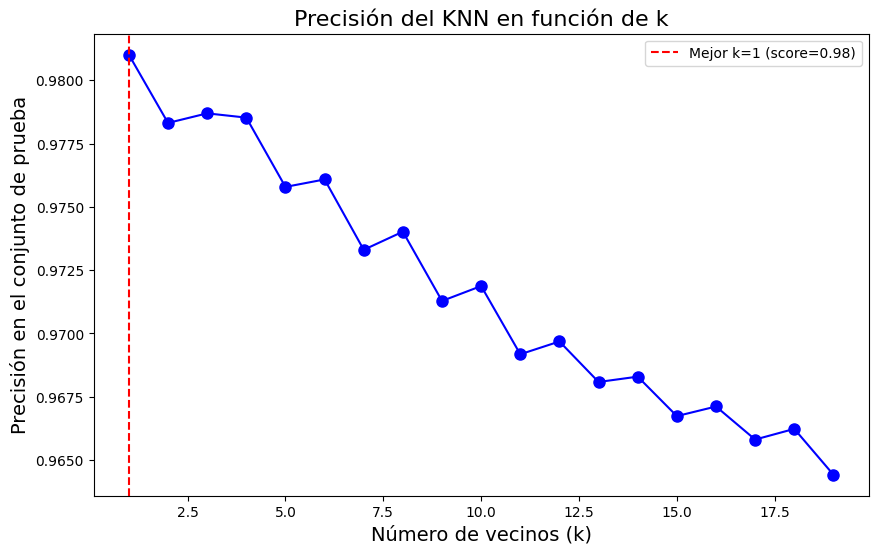

In [ ]:
k_range = range(1, 20)
scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k, algorithm='ball_tree')
    knn.fit(X_train, y_train)
    scores.append(knn.score(X_test, y_test))

# Graficar los scores en función del valor de k
plt.figure(figsize=(10, 6))
plt.plot(k_range, scores, marker='o', linestyle='-', color='b', markersize=8)

# Agregar etiquetas y título
plt.xlabel('Número de vecinos (k)', fontsize=14)
plt.ylabel('Precisión en el conjunto de prueba', fontsize=14)
plt.title('Precisión del KNN en función de k', fontsize=16)

# Mostrar la mejor precisión en el gráfico
best_k = k_range[scores.index(max(scores))]
best_score = max(scores)
plt.axvline(x=best_k, color='r', linestyle='--', label=f'Mejor k={best_k} (score={best_score:.2f})')

# Agregar leyenda
plt.legend(loc='best')
plt.show()

Este grafico nos indica que el mejor valor de K para el modelo de clasificacion de KNeighbors es de 1

Esto indica que el modelo realizara las predicciones buscando al vecino mas cercano **(1)**

In [ ]:
model_knn = KNeighborsClassifier(1)
model_knn.fit(X_train, y_train)
print('Accuracy of K-NN classifier en el conjunto de entrenamiento: {:.2f}'
     .format(model_knn.score(X_train, y_train)))
print('Accuracy of K-NN classifier en el conjunto de test: {:.2f}'
     .format(model_knn.score(X_test, y_test)))

pred_knn = model_knn.predict(X_test)
report_knn = classification_report(y_test, pred_knn)
print(report_knn)

Accuracy of K-NN classifier en el conjunto de entrenamiento: 1.00
Accuracy of K-NN classifier en el conjunto de test: 0.98
              precision    recall  f1-score   support

           0       0.99      0.97      0.98     14165
           1       0.96      0.99      0.98      9583

    accuracy                           0.98     23748
   macro avg       0.98      0.98      0.98     23748
weighted avg       0.98      0.98      0.98     23748



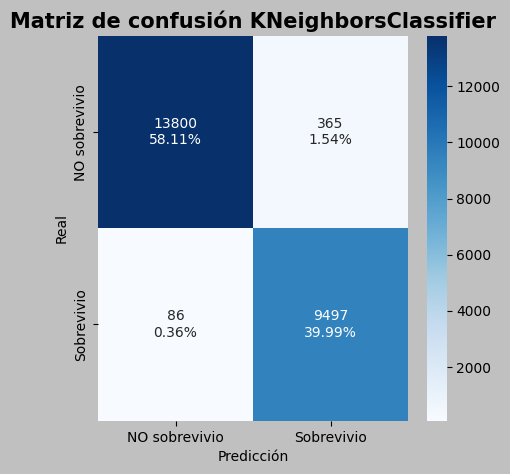

In [ ]:
view_matriz(model_knn, X_test, y_test, target_matriz, "KNeighborsClassifier")

Como podemos observar el modelo en si tiene un margen de error bastante minimo ya que en base a sus valores podemos indicar que:

- Clase negativa: El modelo indico que 13800 jugadores no sobrevivieron y en realidad no sobrevivieron, teniendo un margen de error de 1.54% o lo que es igual a que indico que 365 de esos 13800 que indico que murieron en realidad no lo hicieron

- Clase positiva: El modelo indico que 9497 jugadores sobrevivieron y en realidad si sobrevivieron, teniendo un margen de error de 0.36% o lo que es igual a que indico que 86 de esos 9497 jugadores que sobrevivieron en realidad no lo hicieron.


Este resultado no es confiable debido a que nuestro set de datos tiene un desbalance de clases. Es recomendable que se aplique un tratamiento de balanceo de clases para poder generar una matriz de confusion con valores mas confiables.

## Modelo 2: DecisionTreeClassifier

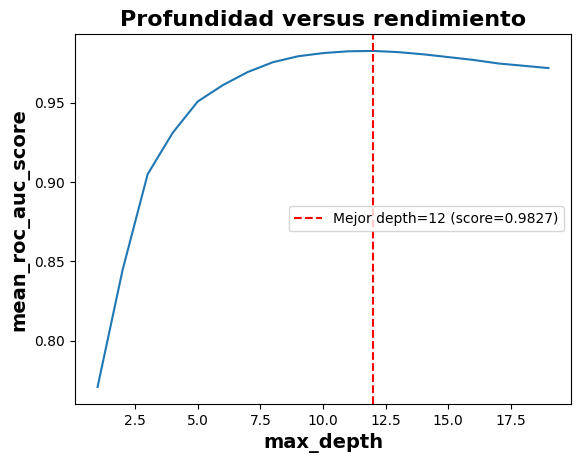

In [ ]:
depths = range(1,20)
performances, performances_x, performances_recall, performances_f1, performances_precision = [], [], [], [], []
for depth in depths:
    # Crea el modelo
    current_tree = DecisionTreeClassifier(max_depth=depth, criterion = "entropy")
    # Calcula la métrica ROC_AUC
    roc_auc = cross_val_score(
          current_tree,
          X,
          y,
          scoring="roc_auc"
      ).mean()
    performances.append(roc_auc)
    # Calcula el accuracy
    accuracy = cross_val_score(
          current_tree,
          X,
          y,
          scoring="accuracy"
      ).mean()
    performances_x.append(accuracy)
    # Calcula el recall
    recall = cross_val_score(
          current_tree,
          X,
          y,
          scoring="recall"
      ).mean()
    performances_recall.append(recall)
    # Calcula el F1-score
    f1_score_decission = cross_val_score(
          current_tree,
          X,
          y,
          scoring="f1"
      ).mean()
    performances_f1.append(f1_score_decission)

    # Calcula precision
    precision_score = cross_val_score(
          current_tree,
          X,
          y,
          scoring="precision"
      ).mean()
    performances_precision.append(precision_score)

plt.plot(depths, performances)
# Mostrar la mejor precisión en el gráfico
best_depth = depths[performances.index(max(performances))]
best_score = max(performances)
plt.axvline(x=best_depth, color='r', linestyle='--', label=f'Mejor depth={best_depth} (score={best_score:.4f})')

plt.xlabel("max_depth", fontsize=14, fontweight="bold")
plt.ylabel("mean_roc_auc_score", fontsize=14, fontweight="bold")
plt.title("Profundidad versus rendimiento", fontsize=16, fontweight="bold")
# Agregar leyenda
plt.legend(loc='right')
plt.show()

Este grafico nos indica que el mejor valor para el parametro de max_depth del decisionTreeClassifier es de 12

Esto nos indica que la profundidad maxima del arbol a la hora de crearse sera de 12

In [ ]:
tree_model = DecisionTreeClassifier(max_depth=12, criterion = "gini")

tree_model.fit(X_train, y_train)

pred_tree = tree_model.predict(X_test)
print(classification_report(y_test, pred_tree))

              precision    recall  f1-score   support

           0       0.99      0.95      0.97     14165
           1       0.93      0.98      0.95      9583

    accuracy                           0.96     23748
   macro avg       0.96      0.96      0.96     23748
weighted avg       0.96      0.96      0.96     23748



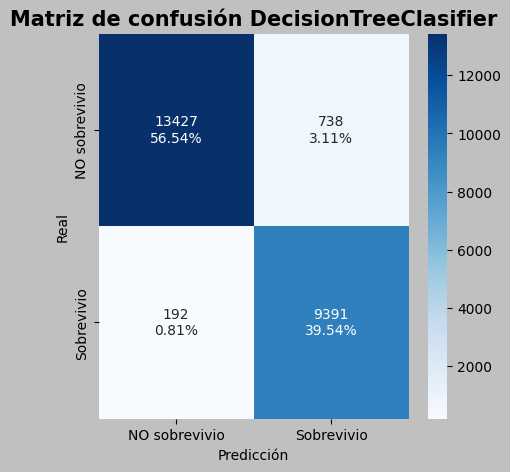

In [ ]:
view_matriz(tree_model, X_test, y_test, target_matriz, "DecisionTreeClasifier")

Como podemos observar el modelo en si tiene un margen de error bastante minimo ya que en base a sus valores podemos indicar que:

- Clase negativa: El modelo indico que 13427 jugadores no sobrevivieron y en realidad no sobrevivieron, teniendo un margen de error de 1.54% o lo que es igual a que indico que 738 de esos 13427 que indico que murieron en realidad no lo hicieron

- Clase positiva: El modelo indico que 9391 jugadores sobrevivieron y en realidad si sobrevivieron, teniendo un margen de error de 0.36% o lo que es igual a que indico que 192 de esos 9391 jugadores que sobrevivieron en realidad no lo hicieron.


Este resultado no es confiable debido a que nuestro set de datos tiene un desbalance de clases. Es recomendable que se aplique un tratamiento de balanceo de clases para poder generar una matriz de confusion con valores mas confiables.

## Modelo 3: RandomForest

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Mejores parámetros: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 10, 'random_state': 25}
AUC en el conjunto de prueba: 0.99


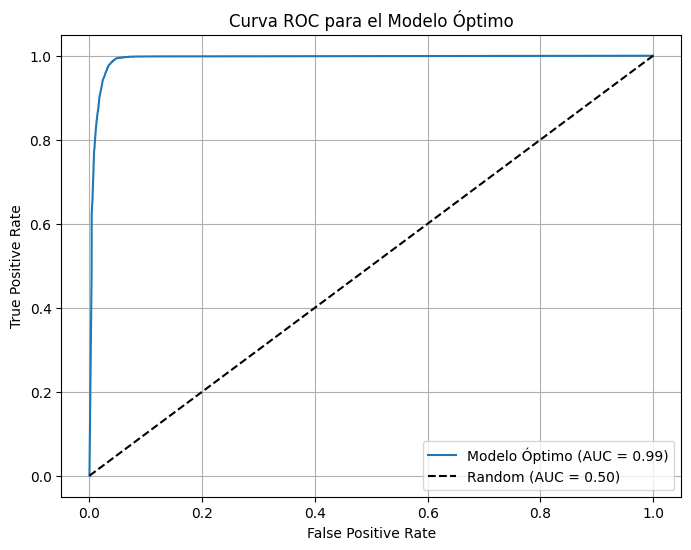

In [ ]:
# Definir el modelo base
rf = RandomForestClassifier()

# Especificar los hiperparámetros a buscar
param_grid = {
    'random_state': [25,30,45,50],
    'n_estimators': [1,10],
    'max_depth': [None, 5,10],
    'min_samples_split': [2,3,4],
    'min_samples_leaf': [1, 2, 4]
}

# Configurar GridSearchCV
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='roc_auc',  # Optimizar AUC
    cv=5,               # Validación cruzada con 5 particiones
    verbose=2,
    n_jobs=-1
)

# Realizar la búsqueda
grid_search.fit(X_train, y_train)

# Obtener los mejores parámetros y el mejor modelo
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
print(f"Mejores parámetros: {best_params}")
# Predecir probabilidades en el conjunto de prueba
y_pred_prob = best_model.predict_proba(X_test)[:, 1]

# Calcular AUC en el conjunto de prueba
auc_score = roc_auc_score(y_test, y_pred_prob)
print(f"AUC en el conjunto de prueba: {auc_score:.2f}")

# Calcular los valores de la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"Modelo Óptimo (AUC = {auc_score:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random (AUC = 0.50)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC para el Modelo Óptimo")
plt.legend(loc="lower right")
plt.grid()

Este grafico nos entrega los mejores parametros para el modelo de Random forest

Esto nos indica que el modelo creara y buscara el mejor arbol en base a los siguientes:

max_depth: None -> Nos indica que no habra una profundidad maxima, es decir, el modelo lo ajustara de forma automatica de acorde a los datos

min_samples_leaf:2 -> Indica que deben haber minimo 2 muestras para que un nodo sea una hoja

min_samples_split: 2 -> Indica que deben haber minimo 2 muestras para dividir un nodo interno

n_estimators: 10 -> Indica que creara 10 arboles en el bosque como maximo para poder evaluar sus rendimientos y entregarnos el mejor

random_state: 25 -> Establece una semilla para los generadores aleatorios utilizados en el entrenamiento

In [ ]:
randon_model = RandomForestClassifier(max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators= 10, random_state= 25)
randon_model.fit(X_train, y_train)

pred_randon = randon_model.predict(X_test)
print(classification_report(y_test, pred_randon))

              precision    recall  f1-score   support

           0       0.99      0.96      0.97     14165
           1       0.94      0.99      0.96      9583

    accuracy                           0.97     23748
   macro avg       0.97      0.97      0.97     23748
weighted avg       0.97      0.97      0.97     23748



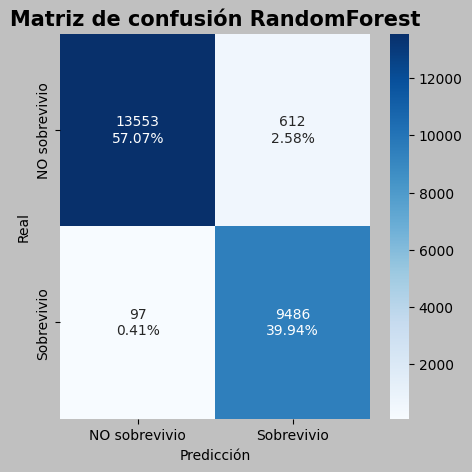

In [ ]:
view_matriz(randon_model, X_test, y_test, target_matriz, "RandomForest")

Como podemos observar el modelo en si tiene un margen de error bastante minimo ya que en base a sus valores podemos indicar que:

- Clase negativa: El modelo indico que 13553 jugadores no sobrevivieron y en realidad no sobrevivieron, teniendo un margen de error de 1.54% o lo que es igual a que indico que 612 de esos 13553 que indico que murieron en realidad no lo hicieron

- Clase positiva: El modelo indico que 9486 jugadores sobrevivieron y en realidad si sobrevivieron, teniendo un margen de error de 0.36% o lo que es igual a que indico que 97 de esos 9486 jugadores que sobrevivieron en realidad no lo hicieron.


Este resultado no es confiable debido a que nuestro set de datos tiene un desbalance de clases. Es recomendable que se aplique un tratamiento de balanceo de clases para poder generar una matriz de confusion con valores mas confiables.

## Modelo 4: SVM

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Mejores hiperparámetros: {'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}
AUC-ROC en el conjunto de prueba: 0.9737756946121681


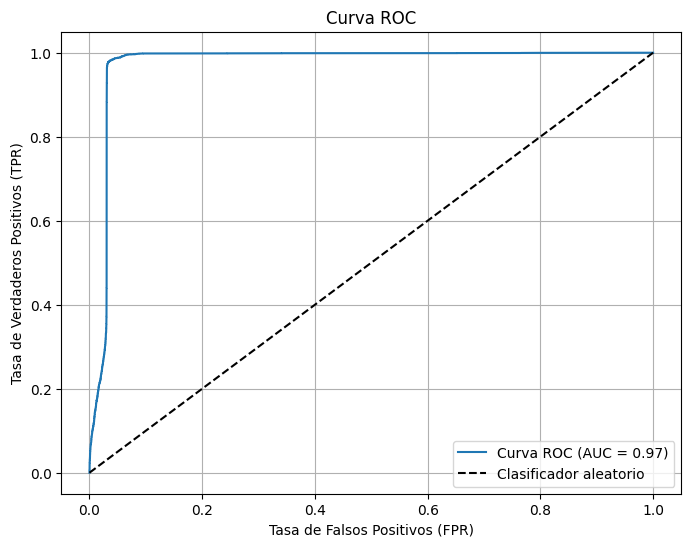

In [ ]:
svm = SVC(probability=True)  # probability=True es necesario para obtener las probabilidades requeridas por la curva ROC

# Definir el espacio de búsqueda de hiperparámetros
param_grid = {
    'C': [0.1],           # Parámetro de regularización
    'gamma': [1],   # Coeficiente del kernel RBF
    'kernel': ['rbf']       # Tipos de kernel
}

# Configurar la búsqueda de hiperparámetros
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, scoring='roc_auc', cv=5, verbose=1)

# Realizar la búsqueda
grid_search.fit(X_train, y_train)

# Obtener los mejores hiperparámetros y el modelo
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Evaluar el modelo en el conjunto de prueba
y_proba = best_model.predict_proba(X_test)[:, 1]  # Obtener las probabilidades de la clase positiva
auc_roc = roc_auc_score(y_test, y_proba)

print("Mejores hiperparámetros:", best_params)
print("AUC-ROC en el conjunto de prueba:", auc_roc)

# Graficar la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Curva ROC (AUC = {auc_roc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Clasificador aleatorio')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.grid()
plt.show()

Este grafico nos indica los mejores parametros para el modelo de SVM

Esto nos indica que los siguientes parametros:

C: 0.1 -> Indica la regularizacion del modelo para balancear su complejidad y el margen de clasificacion.

Gamma: 1 -> Indica como afecta cada punto de los valores al modelo

Kernel: rbf -> Indica el tipo de funcion de nucleo utilizada para transformar los datos en un espacio de mayor dimension

In [ ]:
svm_model = SVC( C = 0.1, gamma = 1, kernel='rbf')
svm_model.fit(X_train, y_train)

pred_svm = svm_model.predict(X_test)
print(classification_report(y_test, pred_svm))

              precision    recall  f1-score   support

           0       1.00      0.92      0.96     14165
           1       0.89      1.00      0.94      9583

    accuracy                           0.95     23748
   macro avg       0.95      0.96      0.95     23748
weighted avg       0.96      0.95      0.95     23748



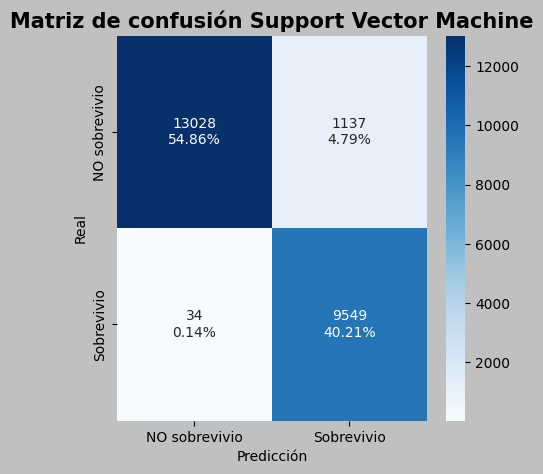

In [ ]:
view_matriz(svm_model, X_test, y_test, target_matriz, "Support Vector Machine")

Como podemos observar el modelo en si tiene un margen de error bastante minimo ya que en base a sus valores podemos indicar que:

- Clase negativa: El modelo indico que 13028 jugadores no sobrevivieron y en realidad no sobrevivieron, teniendo un margen de error de 1.54% o lo que es igual a que indico que 1137 de esos 13028 que indico que murieron en realidad no lo hicieron

- Clase positiva: El modelo indico que 9549 jugadores sobrevivieron y en realidad si sobrevivieron, teniendo un margen de error de 0.36% o lo que es igual a que indico que 34 de esos 9549 jugadores que sobrevivieron en realidad no lo hicieron.


Este resultado no es confiable debido a que nuestro set de datos tiene un desbalance de clases. Es recomendable que se aplique un tratamiento de balanceo de clases para poder generar una matriz de confusion con valores mas confiables.

# Fase 5 - Evaluación

En este caso, tomando en cuenta la representatividad de nuestra variable objetivo en el negocio, se decidio que la metrica mas relevante para indicar que modelo es el mejor sera F1-score

Esto debido a que F1-score representa un balance optimo entre las metricas de precision y recall.

A continuacion aplicaremos una funcion la cual tomara todos los modelos, calculara la metrica y nos entregara el mejor.

In [ ]:
models = {
    "KNN": model_knn,
    "DecisionTreeClassifier": tree_model,
    "RandomForest": randon_model,
    "SVM": svm_model
}



best_model, scores = get_best_model_by_f1(models, X_test, y_test)
print("El mejor modelo, basandonos en la metrica de F1-score, es el modelo {} con un F1-score de {}".format(best_model, scores))

F1 Scores de los modelos: {'KNN': 0.9810507263431412, 'DecisionTreeClassifier': 0.96099637773713, 'RandomForest': 0.9702590827764008, 'SVM': 0.9510334530448834}
Mejor modelo: KNN
Scores: 0.9810507263431412


In [ ]:
report_knn = classification_report(y_test, pred_knn)
print(report_knn)

              precision    recall  f1-score   support

           0       0.99      0.97      0.98     14165
           1       0.96      0.99      0.98      9583

    accuracy                           0.98     23748
   macro avg       0.98      0.98      0.98     23748
weighted avg       0.98      0.98      0.98     23748



Tomando ahora todas las metricas disponibles de nuestro mejor modelo (KNN) podemos indicar lo siguiente:

**Accuracy (98%):**

El modelo clasifica correctamente el 98% de las observaciones en promedio, lo que indica un excelente desempeño general. sin embargo, esta metrica es la menos relevante debido a que hay presencia de desbalance de clases ya que en nuestro dataset hay mas jugadores que sobrevivieron una ronda en especifico.

**Precision:**

- Clase 0 (0.99): Cuando el modelo predice la clase 0, acierta el 99% de las veces, lo que indica que no tiene muchas predicciones de que un jugador no sobrevivio cuando en realidad si lo hizo
- Clase 1 (0.96): Para la clase 1, el modelo tiene una precisión del 96%, lo que indica que no tiene muchas predicciones de que un jugador sobrevivio cuando en realidad no lo hizo

**Recall:**

- Clase 0 (0.97): El modelo identifica correctamente el 97% de los casos reales de la clase 0, similar a la precision quiere decir que el modelo tiene pocos errores al predecir que una persona no sobrevivio y que en realidad sobrevivio
- Clase 1 (0.99): Para la clase 1, el modelo identifica correctamente el 99% de los casos reales, teniendo un desempeño excepcional y con pocos errores al decir que un jugador sobrevivio cuando en realidad no lo hizo.

**F1-Score:**

- Clase 0 (0.98): El balance entre precisión y sensibilidad para la clase 0 es sobresaliente, logrando predecir con un buen desempeño que un jugador no sobrevivio cuando en realidad no lo hizo
- Clase 1 (0.98): Para la clase 1, el modelo también logra un excelente equilibrio, logrando predecir con un buen desempeño que un jugador sobrevivio cuando en realidad si lo hizo.

# Fase 6 - Deployment

In [ ]:
best_model = model_knn
data_artificial = pd.DataFrame({
    col: np.random.uniform(data[col].min(), data[col].max(), 5) for col in caracteristicas_ind
})

data_artificial.head(5)

,ScaledTimeAlive,RoundStartingEquipmentValue,RoundKills,AvgKillDistance
0,0.509114,1.817539,-0.376501,16.761713
1,2.415878,-1.389869,4.766146,10.206889
2,-1.612974,-1.090055,3.988650,0.671629
3,2.160130,-1.275589,0.502817,6.563924
4,3.892922,-0.488423,0.729782,11.555356


In [ ]:
X_artificial_PCA = pca.transform(data_artificial[caracteristicas_ind])
X_artificial_PCA.shape

(5, 3)

In [ ]:
data_pca_transformed = pd.DataFrame(X_artificial_PCA)
data_pca_transformed.shape

(5, 3)

In [ ]:
datos_json = data_pca_transformed.to_json(orient="records", indent=4)
print("JSON generado:")
print(datos_json)

# Guardar el JSON en un archivo
with open("datos_artificiales_pca.json", "w") as archivo:
    archivo.write(datos_json)

JSON generado:
[
    {
        "0":10.0443429255,
        "1":2.0857932227,
        "2":-8.2727588334
    },
    {
        "0":9.2976381185,
        "1":-2.5799586861,
        "2":-5.5990511363
    },
    {
        "0":1.7751745672,
        "1":-0.5893942686,
        "2":-2.7141424385
    },
    {
        "0":4.5366969403,
        "1":-1.9575751711,
        "2":-2.8451286197
    },
    {
        "0":8.5105251292,
        "1":-1.9831517103,
        "2":-4.1863723936
    }
]


In [ ]:
file_model = open('best_model.pkl', 'wb')

pickle.dump(best_model , file_model)

file_model.close()

# Pregunta final

¿Qué modelo recomendaría utilizar para cumplir con el objetivo propuesto al inicio? Deberá justificar su respuesta usando los resultados obtenidos